# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>
## <center>Trabajo Práctico 2 : Críticas Cinematográficas </center>
#### Grupo 29:
* Alen Davies Leccese - 107084
* Luca Lazcano - 107044

## Imports y carga de datos

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import sklearn as sk
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, classification_report, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB

import xgboost as xgb
from xgboost import XGBClassifier
import pickle

RANDOM_STATE = 42

In [9]:
train = pd.read_csv('Datasets/train.csv')
test = pd.read_csv('Datasets/test.csv')

In [10]:
train.head()

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo


## Bag of Words

In [11]:
vectorizer = TfidfVectorizer()
train_fid = vectorizer.fit_transform(train.review_es)
test_fid = vectorizer.transform(test.review_es)

## Split train/test

In [12]:
x_train, x_test, y_train, y_test = train_test_split(train_fid,
                                                    train.sentimiento, 
                                                    test_size=0.3,
                                                    random_state=RANDOM_STATE, shuffle=True)

## Bayes Naive

In [13]:
#Cantidad de combinaciones que quiero probar
n=10

#Grilla de Parámetros a probar
params_grid={ 'alpha': [0.5, 1.0, 2.0, 5.0],
               'class_prior': [None, [0.1, 0.9], [0.2, 0.8], [0.3, 0.7], [0.4, 0.6], [0.5, 0.5], [0.6, 0.4]],
               'fit_prior': [True, False],
               'force_alpha': [True, False]
             }
                
#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds, shuffle=True)

#Clasificador
NB_model = MultinomialNB()

# Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score, pos_label='positivo')

#Random Search Cross Validation
rand_NB = RandomizedSearchCV(estimator = NB_model,
                              param_distributions = params_grid,
                              scoring = scorer_fn,
                              cv=kfoldcv,
                              n_iter = n,
                              random_state = RANDOM_STATE) 

rand_NB.fit(x_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=MultinomialNB(),
                   param_distributions={'alpha': [0.5, 1.0, 2.0, 5.0],
                                        'class_prior': [None, [0.1, 0.9],
                                                        [0.2, 0.8], [0.3, 0.7],
                                                        [0.4, 0.6], [0.5, 0.5],
                                                        [0.6, 0.4]],
                                        'fit_prior': [True, False],
                                        'force_alpha': [True, False]},
                   random_state=42,
                   scoring=make_scorer(f1_score, pos_label=positivo))

In [15]:
print('Mejores parámetros: {}'.format(rand_NB.best_params_))
print('Mejor métrica: {}'.format(rand_NB.best_score_))

Mejores parámetros: {'force_alpha': False, 'fit_prior': False, 'class_prior': [0.4, 0.6], 'alpha': 1.0}
Mejor métrica: 0.8494795280730818


In [16]:
NB_model = MultinomialNB().set_params(**rand_NB.best_params_)
NB_model.fit(x_train, y_train)

y_pred = NB_model.predict(x_test)

In [17]:
print(f'Best Training Accuracy: {NB_model.score(x_train, y_train)}')
print(f'Best Testing Accuracy: {NB_model.score(x_test, y_test)}')

Best Training Accuracy: 0.8967428571428572
Best Testing Accuracy: 0.8387333333333333


### Métricas

In [18]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, pos_label='positivo')
f1 = f1_score(y_test, y_pred, pos_label='positivo')
precision = precision_score(y_test, y_pred, pos_label='positivo')

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8387333333333333
Recall: 0.9277902226907366
Precision: 0.7900583482944344
f1 score: 0.8534028240712683


In [19]:
#Reporte de Clasificación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negativo       0.91      0.75      0.82      7411
    positivo       0.79      0.93      0.85      7589

    accuracy                           0.84     15000
   macro avg       0.85      0.84      0.84     15000
weighted avg       0.85      0.84      0.84     15000



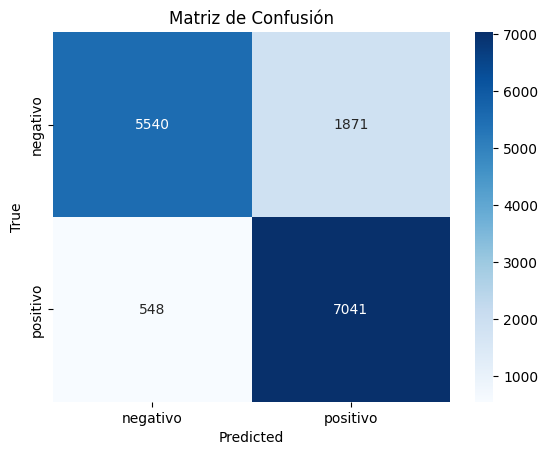

In [20]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g').set(title='Matriz de Confusión', xlabel='Predicted', ylabel='True', xticklabels=['negativo', 'positivo'], yticklabels=['negativo', 'positivo'])
plt.show()

### Submission

In [21]:
pickle.dump(NB_model, open('NB_grupo29.pickle', 'wb'))

In [22]:
X_submission_NB = test_fid
y_pred_test_NB = NB_model.predict(X_submission_NB)
df_submission_NB = pd.DataFrame({'ID': test['ID'], 'sentimiento': y_pred_test_NB})
df_submission_NB.to_csv('NB01.csv', index=False)

## Random Forest

In [23]:
#Cantidad de combinaciones que quiero probar
n=5

#Grilla de Parámetros
params_grid={ 'n_estimators': list(range(10,161,10)),
                'min_samples_split': list(range(2,15)),
                'max_depth': [None],
                'max_samples': np.linspace(0.5,1,n)
             }

#Clasificador
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)

# Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score, pos_label='positivo')

#Random Search Cross Validation
rand_rf = RandomizedSearchCV(estimator = rf_model,
                              param_distributions = params_grid,
                              scoring = scorer_fn,
                              n_iter = n,
                              random_state=RANDOM_STATE) 

rand_rf.fit(x_train, y_train)
rand_rf.cv_results_['mean_test_score'] 

KeyboardInterrupt: 

In [ ]:
print('Mejores parámetros: {}'.format(rand_rf.best_params_))
print('Mejor métrica: {}'.format(rand_rf.best_score_))

Mejores parámetros: {'force_alpha': False, 'fit_prior': False, 'class_prior': [0.4, 0.6], 'alpha': 1.0}
Mejor métrica: 0.8497132270696692


In [1]:
rf_model = RandomForestClassifier(random_state=RANDOM_STATE).set_params(**rand_rf.best_params_)
rf_model.fit(x_train, y_train)

y_pred = rf_model.predict(x_test)

NameError: name 'make_pipeline' is not defined

In [ ]:
print(f'Best Training Accuracy: {rf_model.score(x_train, y_train)}')
print(f'Best Testing Accuracy: {rf_model.score(x_test, y_test)}')

Best Training Accuracy: 0.8953142857142857
Best Testing Accuracy: 0.8395333333333334


### Métricas

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, pos_label='positivo')
f1 = f1_score(y_test, y_pred, pos_label='positivo')
precision = precision_score(y_test, y_pred, pos_label='positivo')

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8395333333333334
Recall: 0.928053762023982
Precision: 0.7909928122192273
f1 score: 0.8540592978839507


In [ ]:
#Reporte de Clasificación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negativo       0.91      0.75      0.82      7411
    positivo       0.79      0.93      0.85      7589

    accuracy                           0.84     15000
   macro avg       0.85      0.84      0.84     15000
weighted avg       0.85      0.84      0.84     15000



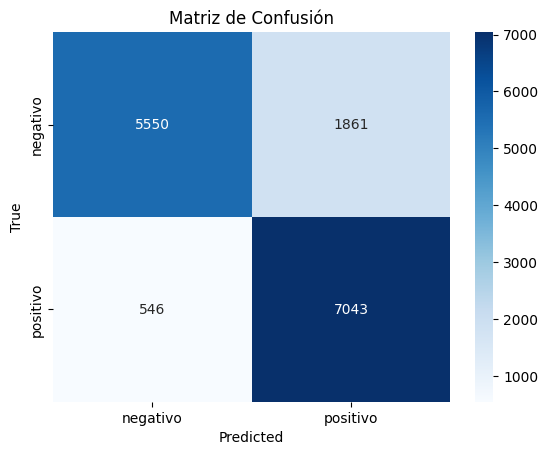

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g').set(title='Matriz de Confusión', xlabel='Predicted', ylabel='True', xticklabels=['negativo', 'positivo'], yticklabels=['negativo', 'positivo'])
plt.show()

### Submission

In [ ]:
pickle.dump(rf_model, open('rf_grupo29.pickle', 'wb'))

In [ ]:
X_submission_rf = test_fid
y_pred_test_rf = rf_model.predict(X_submission_rf)
y_pred_test_rf
df_submission_rf = pd.DataFrame({'ID': test['ID'], 'sentimiento': y_pred_test_rf})
df_submission_rf.to_csv('rf01.csv', index=False)

## XGBoost

In [27]:
#Cantidad de combinaciones que quiero probar
n=5

#Grilla de Parámetros
params_grid= {'learning_rate': np.linspace(0.05, 0.5, 50),
                'gamma': [0,1,2],
                'max_depth': list(range(2,10)),
                'subsample': np.linspace(0, 1, 20),
                'lambda': [0,1,2],
                'alpha' : [1],
                'n_estimators': list(range(10,161,10))
              }

#Clasificador
xgb_model = XGBClassifier(random_state=RANDOM_STATE)

# Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
rand_xgb = RandomizedSearchCV(estimator = xgb_model,
                              param_distributions = params_grid,
                              scoring = scorer_fn,
                              n_iter = n,
                              random_state=RANDOM_STATE) 

label_map = {'negativo': 0, 'positivo': 1}
y_train_mapped = y_train.map(label_map)

rand_xgb.fit(x_train, y_train_mapped)
rand_xgb.cv_results_['mean_test_score'] 

KeyboardInterrupt: 

In [ ]:
print('Mejores parámetros: {}'.format(rand_xgb.best_params_))
print('Mejor métrica: {}'.format(rand_xgb.best_score_))

Mejores parámetros: {'force_alpha': False, 'fit_prior': False, 'class_prior': [0.4, 0.6], 'alpha': 1.0}
Mejor métrica: 0.8497132270696692


In [ ]:
xgb_model = XGBClassifier(random_state=RANDOM_STATE).set_params(**rand_xgb.best_params_)
xgb_model.fit(x_train, y_train)

y_pred = xgb_model.predict(x_test)

In [ ]:
print(f'Best Training Accuracy: {xgb_model.score(x_train, y_train)}')
print(f'Best Testing Accuracy: {xgb_model.score(x_test, y_test)}')

Best Training Accuracy: 0.8953142857142857
Best Testing Accuracy: 0.8395333333333334


### Métricas

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, pos_label='positivo')
f1 = f1_score(y_test, y_pred, pos_label='positivo')
precision = precision_score(y_test, y_pred, pos_label='positivo')

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8395333333333334
Recall: 0.928053762023982
Precision: 0.7909928122192273
f1 score: 0.8540592978839507


In [ ]:
#Reporte de Clasificación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negativo       0.91      0.75      0.82      7411
    positivo       0.79      0.93      0.85      7589

    accuracy                           0.84     15000
   macro avg       0.85      0.84      0.84     15000
weighted avg       0.85      0.84      0.84     15000



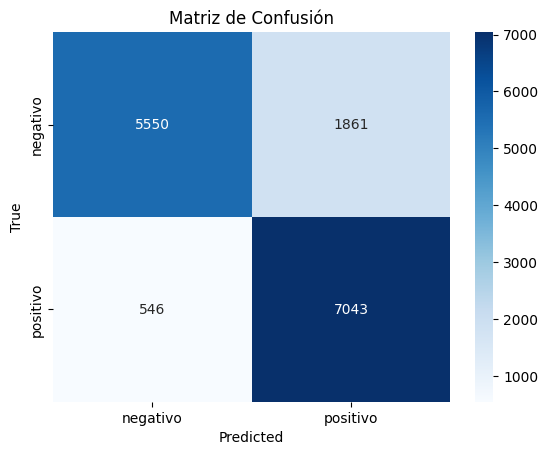

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g').set(title='Matriz de Confusión', xlabel='Predicted', ylabel='True', xticklabels=['negativo', 'positivo'], yticklabels=['negativo', 'positivo'])
plt.show()

### Submission

In [ ]:
pickle.dump(xgb_model, open('xgb_grupo29.pickle', 'wb'))

In [ ]:
X_submission_xgb = test_fid
y_pred_test_xgb = xgb_model.predict(X_submission_xgb)
y_pred_test_xgb
df_submission_xgb = pd.DataFrame({'ID': test['ID'], 'sentimiento': y_pred_test_xgb})
df_submission_xgb.to_csv('xgb00.csv', index=False)

## Red Neuronal

## Ensamble